In [1]:
import numpy as np
import pandas as pd
import pickle

import tensorflow as tf
import math
import json

from sklearn.model_selection import *
from sklearn import metrics

from daf.datasets import atti_dataset
from daf.utils import dataset_utils
from daf.utils import keras_util

from keras.callbacks import TensorBoard

import random

/home/fabio/miniconda3/envs/dl/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Embeddings

In [2]:
(x_train, y_train), (x_test, y_test) = atti_dataset.load_data(num_words=None)
label_index_dict = atti_dataset.get_label_index()

num_words = max([max(x) for x in x_train]) + 1
num_words

34731

In [3]:
print('Total of {} classes'.format(len(label_index_dict)))
label_index_dict

Total of 28 classes


{'ALTRI UFFICI': 0,
 'AVVOCATURA REGIONALE                                  ': 1,
 'D.G.  AVVOCATURA                                      ': 2,
 "D.G. COMPETITIVITA' DEL SISTEMA REGIONALE E SVILUPPO D": 3,
 'D.G. PRESIDENZA                                       ': 4,
 'DIPARTIMENTO BILANCIO E FINANZE                       ': 5,
 'DIPARTIMENTO ORGANIZZAZIONE                           ': 6,
 'DIPARTIMENTO ORGANIZZAZIONE E RISORSE                 ': 7,
 'DIPARTIMENTO POLITICHE FORMATIVE E BENI CULTURALI     ': 8,
 'DIPARTIMENTO POLITICHE TERRITORIALI E AMBIENTALI      ': 9,
 'DIPARTIMENTO PRESIDENZA AFFARI LEGISLATIVI E GIURIDICI': 10,
 'DIPARTIMENTO SALUTE E POLITICHE SOLIDARIETA           ': 11,
 'DIPARTIMENTO SVILUPPO ECONOMICO                       ': 12,
 'DIREZIONE AGRICOLTURA E SVILUPPO RURALE': 13,
 "DIREZIONE ATTIVITA' PRODUTTIVE": 14,
 'DIREZIONE DIFESA DEL SUOLO E PROTEZIONE CIVILE': 15,
 'DIREZIONE DIRITTI DI CITTADINANZA E COESIONE SOCIALE': 16,
 'DIREZIONE GENERALE BILANCIO 

## Data Preparation

We need to create the function that transform the x and y.
In this case we need to:
- x: pad the sequences
- y: one hot encoding

In [4]:
maxlen = max([len(x) for x in x_train])
maxlen

170

In [5]:
from functools import partial

def x_transformer(x_data):
    return partial(tf.keras.preprocessing.sequence.pad_sequences, x_data, maxlen)

def y_tranformer(y_data):
    return partial(dataset_utils.to_one_hot, y_data, num_classes)

In [6]:
batch_size = 128
num_classes = len(set(y_train))
train_val_split = math.ceil(len(x_train) * 0.8)
print('num classes {}'.format(num_classes))
print('training size {}, validation size {}'.format(train_val_split, len(x_train) - train_val_split))

num classes 28
training size 97726, validation size 24431


In [7]:
train_generator = dataset_utils.dataset_generator_fun(x_train, y_train, x_transformer, y_tranformer, 
                                                      batch_size, 0, train_val_split, True)

val_generator = dataset_utils.dataset_generator_fun(x_train, y_train, x_transformer, y_tranformer,
                                                    batch_size, train_val_split, len(x_train), False)

train_steps = train_val_split // batch_size + 1
val_steps = (len(x_train) - train_val_split) // batch_size + 1

## The Effects of Word Embeddings

Before using a word embedding as a layer in our network let evaluate the effect of embeddings by training a simple classifier that has it as only layer.

In [8]:
def build_embed_model(num_words, num_classes, embed_size):
    keras_util.new_session()
    input_l = tf.keras.Input(shape=(maxlen,), dtype='int32')
    embed_l = tf.keras.layers.Embedding(input_dim=num_words, output_dim=embed_size, name='embed')(input_l)
    l = tf.keras.layers.Flatten()(embed_l)
    output_l = tf.keras.layers.Dense(num_classes, activation='softmax')(l)
    model = tf.keras.Model(inputs=input_l, outputs=output_l)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    return model

In [14]:
embed_model = build_embed_model(num_words, num_classes, 100)
embed_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 170)               0         
_________________________________________________________________
embed (Embedding)            (None, 170, 100)          3473100   
_________________________________________________________________
flatten_1 (Flatten)          (None, 17000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 28)                476028    
Total params: 3,949,128
Trainable params: 3,949,128
Non-trainable params: 0
_________________________________________________________________


In [15]:
callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir="logs/{}_{}".format('only_embedding', '64')),
    tf.keras.callbacks.EarlyStopping(patience=3, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(patience=3, verbose=1)
    ]  

In [16]:
embed_model.fit_generator(train_generator, steps_per_epoch=train_steps, epochs=20, 
                          validation_data=val_generator, validation_steps=val_steps, callbacks=callbacks)

Epoch 1/20
764/764 [==============================] - 17s 22ms/step - loss: 9.9189 - acc: 0.2277 - val_loss: 9.6550 - val_acc: 0.2976
Epoch 2/20
764/764 [==============================] - 17s 22ms/step - loss: 9.5855 - acc: 0.3415 - val_loss: 9.5457 - val_acc: 0.3385
Epoch 3/20
764/764 [==============================] - 17s 22ms/step - loss: 9.5162 - acc: 0.3750 - val_loss: 9.4772 - val_acc: 0.3661
Epoch 4/20
764/764 [==============================] - 17s 22ms/step - loss: 9.1911 - acc: 0.3946 - val_loss: 8.5155 - val_acc: 0.4040
Epoch 5/20
764/764 [==============================] - 17s 22ms/step - loss: 4.9121 - acc: 0.5273 - val_loss: 1.3808 - val_acc: 0.6056
Epoch 6/20
764/764 [==============================] - 17s 22ms/step - loss: 0.7934 - acc: 0.7693 - val_loss: 0.9581 - val_acc: 0.7046
Epoch 7/20
764/764 [==============================] - 17s 22ms/step - loss: 0.4831 - acc: 0.8596 - val_loss: 0.8743 - val_acc: 0.7304
Epoch 8/20
764/764 [==============================] - 17s 22ms

## Add an embedding layer to our previous best classifier

In [38]:
def build_model_embedding(neurons, num_words, num_class, embed_size, maxlen, dropout):
    keras_util.new_session()
    input_l = tf.keras.Input(shape=(maxlen,), dtype='int32')
    embed_l = tf.keras.layers.Embedding(input_dim=num_words, output_dim=embed_size, name='embed')(input_l)
    l = tf.keras.layers.Flatten()(embed_l)
    l = tf.keras.layers.Dense(neurons, activation='relu')(l)
    l = tf.keras.layers.Dropout(dropout)(l)
    l = tf.keras.layers.Dense(neurons, activation='relu')(l)
    output_l = tf.keras.layers.Dense(num_classes, activation='softmax')(l)
    model = tf.keras.Model(inputs=input_l, outputs=output_l)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    return model

In [39]:
def train(embeds, epochs):
    histories = {}
    for embed_size in embeds:
        print('*** Network with embedding {} ***'.format(embed_size))
        model = build_model_embedding(128, num_words, num_classes, embed_size, maxlen, 0.1)
        print(model.summary())
        
        callbacks = [
            tf.keras.callbacks.TensorBoard(log_dir="logs/embeds_{}".format(embed_size)),
            tf.keras.callbacks.EarlyStopping(patience=3, verbose=1),
            tf.keras.callbacks.ReduceLROnPlateau(patience=3, verbose=1)
            ]  
        
        history = model.fit_generator(train_generator, steps_per_epoch=train_steps, epochs=epochs, 
                      validation_data=val_generator, validation_steps=val_steps, callbacks=callbacks)

        histories['embed_{}'.format(embed_size)] = history

In [40]:
import gc
gc.collect()

63285

In [41]:
embeds = [100]

histories = train(embeds, 50)

*** Network with embedding 100 ***
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 170)               0         
_________________________________________________________________
embed (Embedding)            (None, 170, 100)          3473100   
_________________________________________________________________
flatten_1 (Flatten)          (None, 17000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               2176128   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 28)  

We can see the there is no improvement in using an embedding layer, but we have milion of parameters with respect to thousand of observations. In the next part we are going to investigate the usage of a pretrained embedding model.

### Use Pre-trained embeddings

In [42]:
id_word_dict = atti_dataset.get_word_index()

import gensim

word2vec_model = gensim.models.Word2Vec.load('../data/dataset/atti.word2vec')

embed_size = word2vec_model.vector_size

counter_not_present =0
embed_matrix = np.zeros((num_words, embed_size))
for i, word in id_word_dict.items():
    if word in word2vec_model:
        vect = word2vec_model[word]
        embed_matrix[int(i)] = vect
    else:
        counter_not_present +=1

counter_not_present

/home/fabio/miniconda3/envs/dl/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if sys.path[0] == '':
/home/fabio/miniconda3/envs/dl/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]


85

In [51]:
def build_model_embedding(neurons, num_words, num_class, embed_size, maxlen, dropout):
    keras_util.new_session()
    input_l = tf.keras.Input(shape=(maxlen,), dtype='int32')
    embed_l = tf.keras.layers.Embedding(input_dim=num_words, output_dim=embed_size, 
                                        weights=[embed_matrix], trainable=False, name='embed')(input_l)
    l = tf.keras.layers.Flatten()(embed_l)
#     l = tf.keras.layers.BatchNormalization()(l)
    l = tf.keras.layers.Dense(neurons, activation='relu')(l)
    l = tf.keras.layers.Dropout(dropout)(l)
#     l = tf.keras.layers.BatchNormalization()(l)
    l = tf.keras.layers.Dense(neurons, activation='relu')(l)
    l = tf.keras.layers.Dropout(dropout)(l)
    l = tf.keras.layers.Dense(neurons, activation='relu')(l)
    output_l = tf.keras.layers.Dense(num_classes, activation='softmax')(l)
    model = tf.keras.Model(inputs=input_l, outputs=output_l)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    return model

In [52]:
model = build_model_embedding(512, num_words, num_classes, embed_size, maxlen, 0.4)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 170)               0         
_________________________________________________________________
embed (Embedding)            (None, 170, 100)          3473100   
_________________________________________________________________
flatten_1 (Flatten)          (None, 17000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               8704512   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
__________

In [53]:
callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir="logs/pre_local_trained_embeds_{}".format(embed_size)),
    tf.keras.callbacks.EarlyStopping(patience=3, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(patience=3, verbose=1)
    ]  

history = model.fit_generator(train_generator, steps_per_epoch=train_steps, epochs=10, 
              validation_data=val_generator, validation_steps=val_steps, callbacks=callbacks)

Epoch 1/10
764/764 [==============================] - 20s 26ms/step - loss: 1.7035 - acc: 0.4786 - val_loss: 1.4125 - val_acc: 0.5602
Epoch 2/10
764/764 [==============================] - 20s 26ms/step - loss: 1.2534 - acc: 0.6018 - val_loss: 1.3110 - val_acc: 0.5829
Epoch 3/10
764/764 [==============================] - 20s 26ms/step - loss: 1.0842 - acc: 0.6539 - val_loss: 1.2529 - val_acc: 0.6029
Epoch 4/10
764/764 [==============================] - 20s 26ms/step - loss: 0.9647 - acc: 0.6913 - val_loss: 1.2383 - val_acc: 0.6090
Epoch 5/10
764/764 [==============================] - 20s 26ms/step - loss: 0.8838 - acc: 0.7179 - val_loss: 1.2349 - val_acc: 0.6181
Epoch 6/10
764/764 [==============================] - 20s 26ms/step - loss: 0.8129 - acc: 0.7406 - val_loss: 1.2193 - val_acc: 0.6246
Epoch 7/10
764/764 [==============================] - 20s 26ms/step - loss: 0.7553 - acc: 0.7588 - val_loss: 1.2262 - val_acc: 0.6288
Epoch 8/10
764/764 [==============================] - 20s 26ms

### Use Italian Pre-trained embeddings

In [54]:
from gensim.models import KeyedVectors

In [55]:
embed_path = '../../utils/cc.it.300.vec/data'
fasttext_model = KeyedVectors.load_word2vec_format(embed_path, binary=False)

We do some queries on the model

In [56]:
fasttext_model.most_similar('approvazione')

[('lapprovazione', 0.6777812838554382),
 ('riapprovazione', 0.6686089038848877),
 ('approvato', 0.6471786499023438),
 ('Approvazione', 0.6427156329154968),
 ('approvazione.', 0.6402238011360168),
 ('approvata', 0.6335983872413635),
 ('approvazioni', 0.6253582239151001),
 ('ratifica', 0.6244692802429199),
 ('allapprovazione', 0.6236387491226196),
 ('approvare', 0.6216689348220825)]

Load the words dictionary

In [57]:
import gc
gc.collect()

0

In [58]:
embed_size = 300

embed_matrix = np.zeros((num_words, embed_size))
for i, word in id_word_dict.items():
    if word in fasttext_model.vocab:
        vect = fasttext_model.get_vector(word)
        embed_matrix[int(i)] = vect
    else:
        counter_not_present +=1

In [59]:
def build_model_embedding(neurons, num_words, num_class, embed_size, maxlen, dropout):
    keras_util.new_session()
    input_l = tf.keras.Input(shape=(maxlen,), dtype='int32')
    embed_l = tf.keras.layers.Embedding(input_dim=num_words, output_dim=embed_size, 
                                        weights=[embed_matrix], trainable=False, name='embed')(input_l)
    l = tf.keras.layers.Flatten()(embed_l)
    l = tf.keras.layers.Dense(neurons, activation='relu')(l)
    l = tf.keras.layers.Dropout(dropout)(l)
    l = tf.keras.layers.Dense(neurons, activation='relu')(l)
    l = tf.keras.layers.Dropout(dropout)(l)
    l = tf.keras.layers.Dense(neurons, activation='relu')(l)
    l = tf.keras.layers.Dropout(dropout)(l)
    output_l = tf.keras.layers.Dense(num_classes, activation='softmax')(l)
    model = tf.keras.Model(inputs=input_l, outputs=output_l)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    return model

In [60]:
model = build_model_embedding(512, num_words, num_classes, embed_size, maxlen, 0.2)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 170)               0         
_________________________________________________________________
embed (Embedding)            (None, 170, 300)          10419300  
_________________________________________________________________
flatten_1 (Flatten)          (None, 51000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               26112512  
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
__________

In [61]:
callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir="logs/pre_trained_embeds_{}".format(embed_size)),
    tf.keras.callbacks.EarlyStopping(patience=3, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(patience=3, verbose=1)
    ]  

history = model.fit_generator(train_generator, steps_per_epoch=train_steps, epochs=10, 
              validation_data=val_generator, validation_steps=val_steps, callbacks=callbacks)

Epoch 1/10
764/764 [==============================] - 44s 58ms/step - loss: 1.8375 - acc: 0.4552 - val_loss: 1.6139 - val_acc: 0.5074
Epoch 2/10
764/764 [==============================] - 44s 57ms/step - loss: 1.2313 - acc: 0.6233 - val_loss: 1.5490 - val_acc: 0.5358
Epoch 3/10
764/764 [==============================] - 44s 57ms/step - loss: 0.9738 - acc: 0.7017 - val_loss: 1.5102 - val_acc: 0.5584
Epoch 4/10
764/764 [==============================] - 44s 58ms/step - loss: 0.8089 - acc: 0.7504 - val_loss: 1.5225 - val_acc: 0.5701
Epoch 5/10
764/764 [==============================] - 44s 57ms/step - loss: 0.6909 - acc: 0.7877 - val_loss: 1.5627 - val_acc: 0.5696
Epoch 6/10
764/764 [==============================] - 44s 57ms/step - loss: 0.5934 - acc: 0.8170 - val_loss: 1.6081 - val_acc: 0.5785
Epoch 00006: early stopping


## Build the final model

the best model is obtained embedding of size 64

In [62]:
import gc
gc.collect()

54173

In [72]:
train_steps = len(x_train) // batch_size + 1

train_generator = dataset_utils.dataset_generator_fun(x_train, y_train, x_transformer, y_tranformer, 
                                                      batch_size, 0, len(x_train), True)

In [74]:
model = build_embed_model(num_words, num_classes, 100)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 170)               0         
_________________________________________________________________
embed (Embedding)            (None, 170, 100)          3473100   
_________________________________________________________________
flatten_1 (Flatten)          (None, 17000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 28)                476028    
Total params: 3,949,128
Trainable params: 3,949,128
Non-trainable params: 0
_________________________________________________________________


In [75]:
history = model.fit_generator(train_generator, train_steps, 11)

Epoch 1/11
955/955 [==============================] - 24s 25ms/step - loss: 6.8825 - acc: 0.2761
Epoch 2/11
955/955 [==============================] - 23s 25ms/step - loss: 6.1880 - acc: 0.4815
Epoch 3/11
955/955 [==============================] - 23s 25ms/step - loss: 5.9055 - acc: 0.5522
Epoch 4/11
955/955 [==============================] - 23s 25ms/step - loss: 5.0268 - acc: 0.6235
Epoch 5/11
955/955 [==============================] - 24s 25ms/step - loss: 2.1946 - acc: 0.7382
Epoch 6/11
955/955 [==============================] - 24s 25ms/step - loss: 0.4596 - acc: 0.8639
Epoch 7/11
955/955 [==============================] - 24s 25ms/step - loss: 0.3109 - acc: 0.9091
Epoch 8/11
955/955 [==============================] - 24s 25ms/step - loss: 0.2285 - acc: 0.9349
Epoch 9/11
955/955 [==============================] - 24s 25ms/step - loss: 0.1698 - acc: 0.9531
Epoch 10/11
955/955 [==============================] - 23s 25ms/step - loss: 0.1281 - acc: 0.9659
Epoch 11/11
955/955 [========

## Evaluate on the test set

In [76]:
import gc
gc.collect()

54381

In [77]:
x_test_v = tf.keras.preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)
y_test_v = dataset_utils.to_one_hot(y_test, num_classes)

In [78]:
test_predictions = model.predict(x_test_v, verbose=1)

30540/30540 [==============================] - 1s 22us/step


In [79]:
predictions = np.array([np.argmax(x) for x in test_predictions])
precision, recall, fscore, _ = metrics.precision_recall_fscore_support(y_test,predictions, average='weighted')
accuracy = metrics.accuracy_score(y_test, predictions)

auc_score = metrics.roc_auc_score(y_test_v, test_predictions, average='weighted')

print('accuracy ', accuracy)
print('precision ', precision)
print('recall ', recall)
print('f-measure ', fscore)

accuracy  0.7865749836280288
precision  0.7902875465853891
recall  0.7865749836280288
f-measure  0.7868511090440478


### Report the classification result for each class

In [80]:
print(metrics.classification_report(y_test, predictions))

             precision    recall  f1-score   support

          0       0.31      0.32      0.31       158
          1       0.55      0.47      0.50       217
          2       0.83      0.85      0.84       686
          3       0.80      0.76      0.78      2765
          4       0.80      0.80      0.80      1658
          5       0.67      0.57      0.62       289
          6       0.57      0.68      0.62       606
          7       0.51      0.41      0.45       316
          8       0.64      0.75      0.69       669
          9       0.86      0.73      0.79      1432
         10       0.67      0.73      0.70       542
         11       0.71      0.70      0.71       767
         12       0.72      0.67      0.69       985
         13       0.95      0.96      0.95      2718
         14       0.68      0.70      0.69       370
         15       0.97      0.91      0.93      1142
         16       0.86      0.79      0.82      1890
         17       0.60      0.71      0.65   

### Confusion Matrix

In [81]:
conf_matrix = metrics.confusion_matrix(y_test, predictions)

In [82]:
import itertools
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
np.set_printoptions(precision=2)

Confusion matrix, without normalization


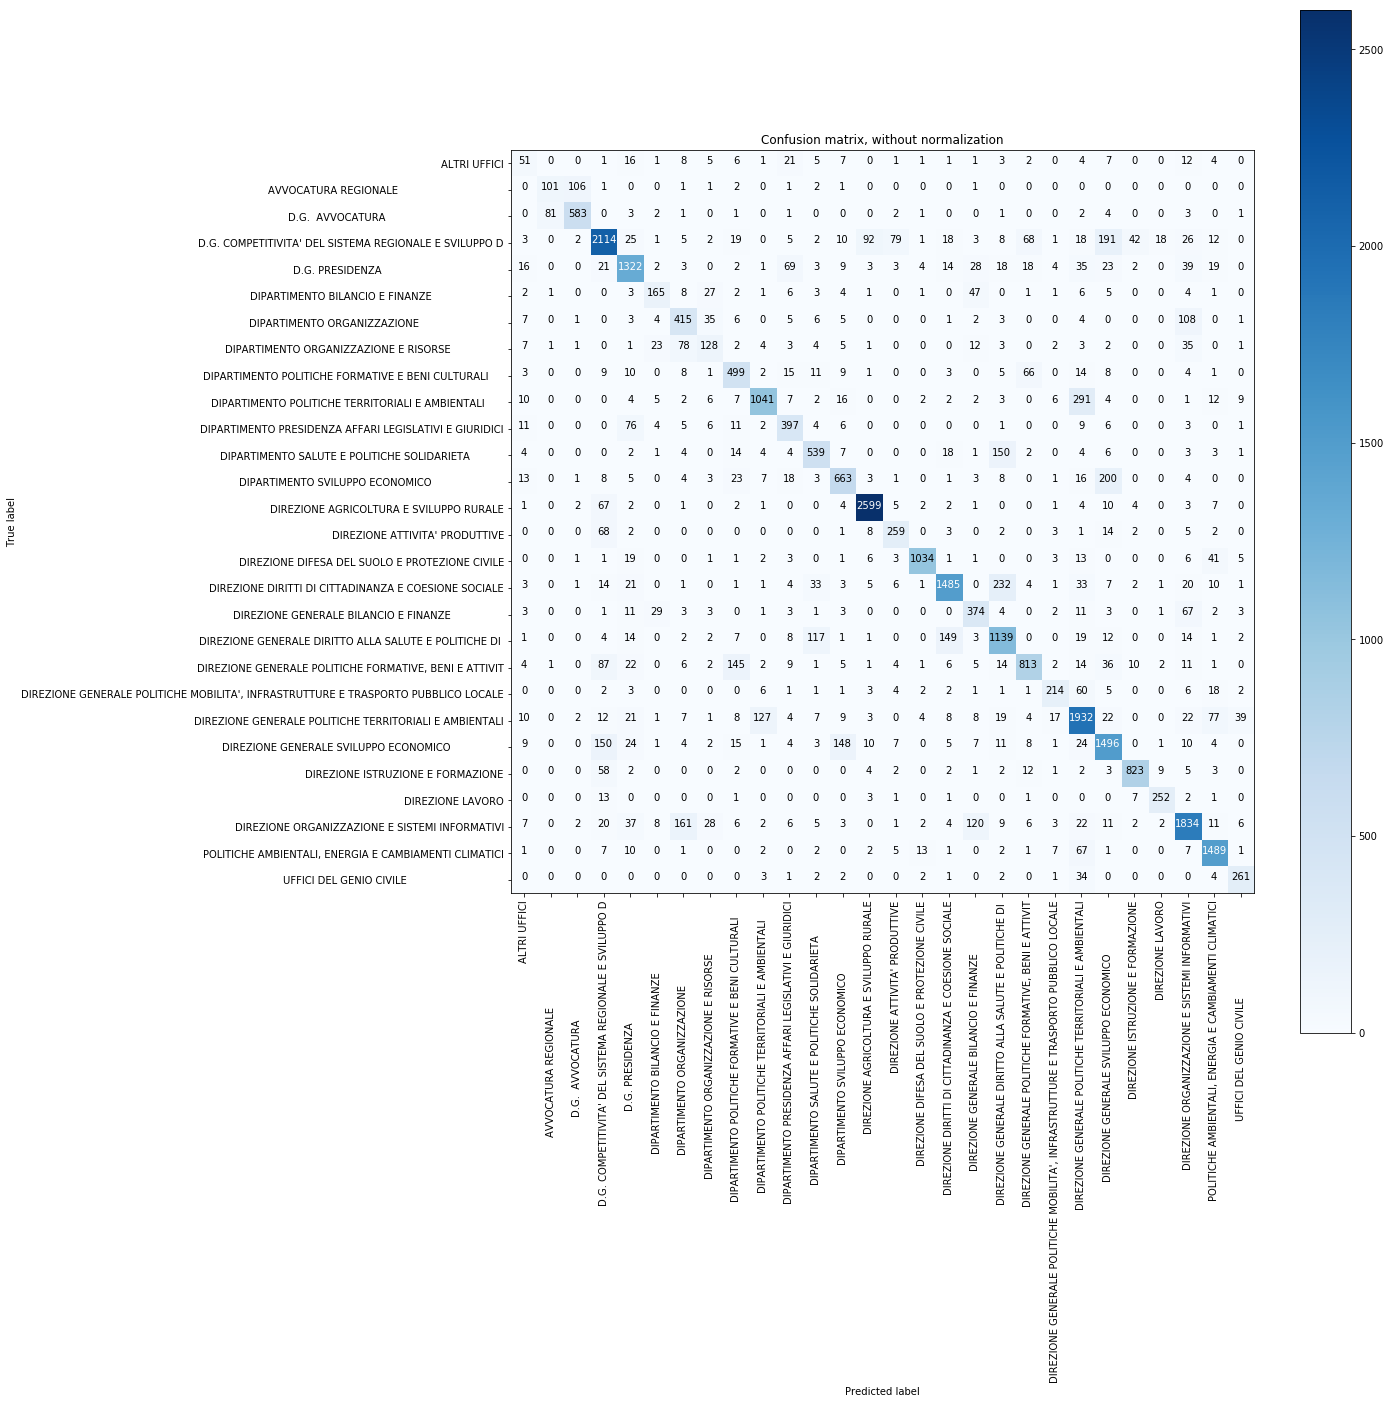

In [83]:
plt.rcParams['figure.figsize'] = (20,20)
plot_confusion_matrix(conf_matrix, classes=label_index_dict,
                      title='Confusion matrix, without normalization')